## Analysing daily PQs

In [2]:
import pandas as pd
import re
import requests
from matplotlib import pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [3]:
!python download.py

tmp folder already exists.
File pqs.csv found with 383178 answered PQs in, last updated 2022-03-02. Looking for new PQs...
Downloaded 147 new PQs, which have been add to the archive.                     
File ua_pqs.csv found with 385417 unanswered PQs in, last updated 2022-03-23. Looking for new PQs...
Downloaded 0 new PQs, which have been add to the archive.                       


In [4]:
# Naughtily, we're importing a database of MP ids & party affiliations from elsewhere... 
active_p = pd.read_csv('active_members.csv')
former_p = pd.read_csv('former_members.csv')

all_p = pd.concat([active_p, former_p])
all_p = all_p[['id', 'nameListAs', 'gender', 'latestPartyabbreviation']]

In [5]:
# Check we get Angie Rayner here
all_p[all_p.id == 4356]

,id,nameListAs,gender,latestPartyabbreviation
437,4356,"Rayner, Angela",F,Lab


In [6]:
id_party_dict = dict(zip(all_p.id, all_p.latestPartyabbreviation))

In [7]:
wpqs = pd.read_csv('tmp/ua_pqs.csv')
wpqs['dateTabled'] = pd.to_datetime(wpqs.dateTabled)
wpqs['heading'] = wpqs.heading.fillna('')
# wpqs = wpqs[['id', 'askingMemberId', 'askingMember', 'house', 'dateTabled', 'questionText', 'answeringBodyName', 'heading']]

# Populate a column with party appreviation in the WPQs database
wpqs['latestPartyabbreviation'] = wpqs.askingMemberId.progress_apply(lambda x: id_party_dict[x] if x in id_party_dict.keys() else 'n/a')

# Make some of the string fields lower case to improve comparability and searchability
wpqs['heading'] = wpqs.heading.progress_apply(lambda x: x.lower())
wpqs['questionText'] = wpqs.questionText.progress_apply(lambda x: x.lower())

# Sometime the heading is a generic topic, other times it's specified by a ":" symbol. We'll extract this into a 'topic' column.
wpqs['topic'] = wpqs.heading.progress_apply(lambda x: x.split(':')[0])

wpqs['year_month'] = wpqs.dateTabled.dt.to_period('M')

100%|███████████████████████████████████| 385417/385417 [00:00<00:00, 1525045.70it/s]


In [8]:
# Cleaning up the question text

# Aim: to get the bit of text after the 'to ask the secretary of state for blah blah, if...'

def question_cleaner(question):
    q = re.sub(r',(?=\S)|:', ', ', question)
    q = q.replace("to ask her majesty's government ", "to ask her majesty's government, ").replace("to ask her majesty’s government ", "to ask her majesty's government, ")
    q = q.replace(', and', ' and').replace('foreign, commonwealth and development affairs', 'foreign commonwealth and development affairs').replace('digital, culture, media', 'digital culture media').replace('business, energy and industrial', 'business energy and industrial')
    q = q.replace('levelling up, housing and', 'levelling up housing and').replace('environment, food and rural affairs', 'environment food and rural affairs').replace('culture, media and sport', 'culture media and sport').replace('business, innovation and skills', 'business innovation and skills')
    q = q.replace('digital, culture, media and sport', 'digital culture media and sport')
    q = q.replace('housing, communities and local government', 'housing communities and local government')
    q = q.replace(', representing the church commissioners', ' representing the church commissioners, ') 
    q = q.replace('to ask the chairman of committees ', 'to ask the chairman of committees, ')
    q = q.replace('to ask the leader of the house ', 'to ask the leader of the house, ')
    q = q.replace("to ask her majesty’s government", "to ask her majesty's government, ")
    q = q.replace("to ask the senior deputy speaker ", "to ask the senior deputy speaker, ")
    q = q.replace("her majesty's government ", "her majesty's government, ")
    q = q.replace("to ask the secretary of state for education ", "to ask the secretary of state for education, ")
    q = q.replace("to ask the secretary of state for defence ", "to ask the secretary of state for defence, ")
    q = q.replace("to ask the secretary of state for work and pensions ", "to ask the secretary of state for work and pensions, ")
    q = q.replace("to ask the secretary of state for environment food and rural affairs ", "to ask the secretary of state for environment food and rural affairs, ")
    q = q.replace("to ask the secretary of state for health ", "to ask the secretary of state for health, ")
    q = q.replace("foreign and commonwealth affairs ", "foreign and commonwealth affairs, ")
    q = q.replace("foreign commonwealth and development affairs ", "foreign commonwealth and development affairs, ")
    q = q.replace("the senior deputy speaker ", "the senior deputy speaker, ")
    q = q.replace("secretary of state for the home department,", "secretary of state for the home department, ")
    q = q.replace("to ask mr chancellor of the exchequer ", "to ask mr chancellor of the exchequer, ")
    q = q.replace("to ask the minister of the cabinet office ", "to ask the minister of the cabinet office, ")
    q = q.replace("to ask the minister for the cabinet office ", "to ask the minister for the cabinet office, ")
    q = q.replace("to ask the secretary of state for communities and local government ", "to ask the secretary of state for communities and local government, ")
    q = ' '.join(q.split(', ')[1:])
    cleaned_question = q
    return cleaned_question

wpqs['cleanedQuestion'] = wpqs.questionText.progress_apply(lambda x: question_cleaner(x))

100%|████████████████████████████████████| 385417/385417 [00:03<00:00, 105700.18it/s]


In [9]:
wpqs.head()

,id,askingMemberId,askingMember,house,memberHasInterest,dateTabled,dateForAnswer,uin,questionText,answeringBodyId,answeringBodyName,heading,latestPartyabbreviation,topic,year_month,cleanedQuestion
0,58429,437,NaN,Commons,False,2014-06-05,2014-06-09T00:00:00,199151,"to ask mr chancellor of the exchequer, how muc...",14,HM Treasury,working tax credit: bolton,Lab,working tax credit,2014-06,how much has been paid through working tax cre...
1,57913,4031,NaN,Commons,False,2014-06-04,2014-06-09T00:00:00,198956,"to ask mr chancellor of the exchequer, what th...",14,HM Treasury,welfare tax credits,Lab,welfare tax credits,2014-06,what the value was of the average claim for ta...
2,61038,4031,NaN,Commons,False,2014-06-10,2014-06-16T00:00:00,199850,"to ask mr chancellor of the exchequer, what th...",14,HM Treasury,welfare tax credits,Lab,welfare tax credits,2014-06,what the total value was of tax credits paid t...
3,64002,163,NaN,Commons,False,2014-06-25,2014-06-30T00:00:00,202509,"to ask mr chancellor of the exchequer, how man...",14,HM Treasury,welfare tax credits: self-employed,Lab,welfare tax credits,2014-06,how many self-employed people claimed (a) chil...
4,64577,385,NaN,Commons,False,2014-06-27,2014-07-01T00:00:00,202934,"to ask mr chancellor of the exchequer, how man...",14,HM Treasury,welfare tax credits: york,Lab,welfare tax credits,2014-06,how many families in (a) york central constitu...


### Daily by departments

In [10]:
dept = wpqs.copy()
dept = dept[dept.house == 'Commons']
dept = dept[['dateTabled', 'year_month', 'answeringBodyName', 'heading', 'topic', 'latestPartyabbreviation', 'cleanedQuestion', 'askingMemberId']]

In [11]:
# Total number of PQs facing each department every day
dept_total = dept.groupby(['dateTabled', 'answeringBodyName']).nunique()
dept_total = dept_total.reset_index('answeringBodyName')[['answeringBodyName', 'cleanedQuestion']]

In [12]:
dept_total.head()

,answeringBodyName,askingMemberId
dateTabled,,
2014-06-04,Attorney General,1
2014-06-04,Cabinet Office,26
2014-06-04,"Department for Business, Innovation and Skills",42
2014-06-04,Department for Communities and Local Government,28
2014-06-04,"Department for Culture, Media and Sport",11


In [ ]:
dept_total_wide = dept_total.pivot(columns='answeringBodyName', values='cleanedQuestion')

In [ ]:
# Remove rows where Parliament probably isn't sitting and there's either a mistake in the data, or just very few questions tabled. 

dept_total_wide = dept_total_wide.dropna(axis=0, thresh=15)

<AxesSubplot:xlabel='dateTabled'>

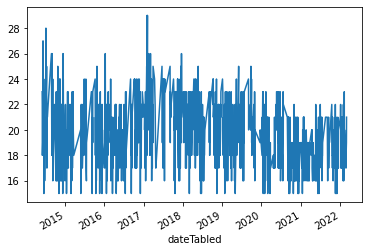

In [ ]:
dept_total_wide.notna().sum(axis=1).plot()

In [ ]:
dept_total_wide = dept_total_wide.fillna(0)

In [ ]:
# Regularise departments
dept_total_wide['HM Treasury'] = dept_total_wide[['Treasury', 'HM Treasury']].sum(axis=1)

dept_total_wide['Cabinet Office'] = dept_total_wide[['Cabinet Office', 'Chancellor of the Duchy of Lancaster', 'Chancellor of the Duchy of Lancaster and Minister for the Cabinet Office']].sum(axis=1)

dept_total_wide['Department for Business, Energy and Industrial Strategy'] = dept_total_wide[[
    'Department for Business, Energy and Industrial Strategy', 
    'Department for Business, Innovation and Skills', 
    'Department for Energy and Climate Change',
]].sum(axis=1)

dept_total_wide['Department for Levelling Up, Housing and Communities'] = dept_total_wide[[
    'Department for Levelling Up, Housing and Communities', 
    'Department for Communities and Local Government', 
    'Ministry for Housing, Communities and Local Government',
    'Ministry of Housing, Communities and Local Government',
]].sum(axis=1)

dept_total_wide['Department for Digital, Culture, Media and Sport'] = dept_total_wide[[
    'Department for Digital, Culture, Media and Sport', 
    'Department for Culture, Media and Sport', 
]].sum(axis=1)

dept_total_wide['Department of Health and Social Care'] = dept_total_wide[[
    'Department of Health',
    'Department of Health and Social Care'
]].sum(axis=1)

dept_total_wide['Foreign, Commonwealth and Development Office'] = dept_total_wide[[
    'Foreign and Commonwealth Office',
    'Foreign, Commonwealth and Development Office'
]].sum(axis=1)

dept_total_wide.drop(columns = [
    'Treasury', 
    'Chancellor of the Duchy of Lancaster', 
    'Chancellor of the Duchy of Lancaster and Minister for the Cabinet Office',
    'Department for Business, Innovation and Skills', 
    'Department for Energy and Climate Change',
    'Department for Levelling Up, Housing and Communities', 
    'Department for Communities and Local Government', 
    'Ministry for Housing, Communities and Local Government',
    'Ministry of Housing, Communities and Local Government',    
    'Department for Digital, Culture, Media and Sport', 
    'Department for Culture, Media and Sport',
    'Department of Health', 
    'Foreign and Commonwealth Office', 
], inplace=True)

In [ ]:
# Select only government departments

dept_total_wide = dept_total_wide[[
    'COP26', 
    'Cabinet Office', 
    'Department for Business, Energy and Industrial Strategy',
    'Department for Education',
    'Department for Environment, Food and Rural Affairs',
    'Department for Exiting the European Union ',
    'Department for International Development',
    'Department for International Trade', 'Department for Transport',
    'Department for Work and Pensions',
    'Department of Health and Social Care',
    'Foreign, Commonwealth and Development Office', 
    'HM Treasury',
    'Home Office',
    'Ministry of Defence', 
    'Ministry of Justice', 
    'Northern Ireland Office',
    'Scotland Office',
    'Wales Office',
    'Women and Equalities'
]]

In [ ]:
# dept_total_wide = dept_total_wide.fillna(0)

dept_total_wide_rolling = dept_total_wide.rolling(7).mean()
dept_total_wide_per = dept_total_wide.copy()

In [ ]:
dept_total_wide_per = dept_total_wide_per.div(dept_total_wide_per.sum(axis=1), axis=0)
dept_total_wide_rolling = dept_total_wide_rolling.div(dept_total_wide_rolling.sum(axis=1), axis=0)

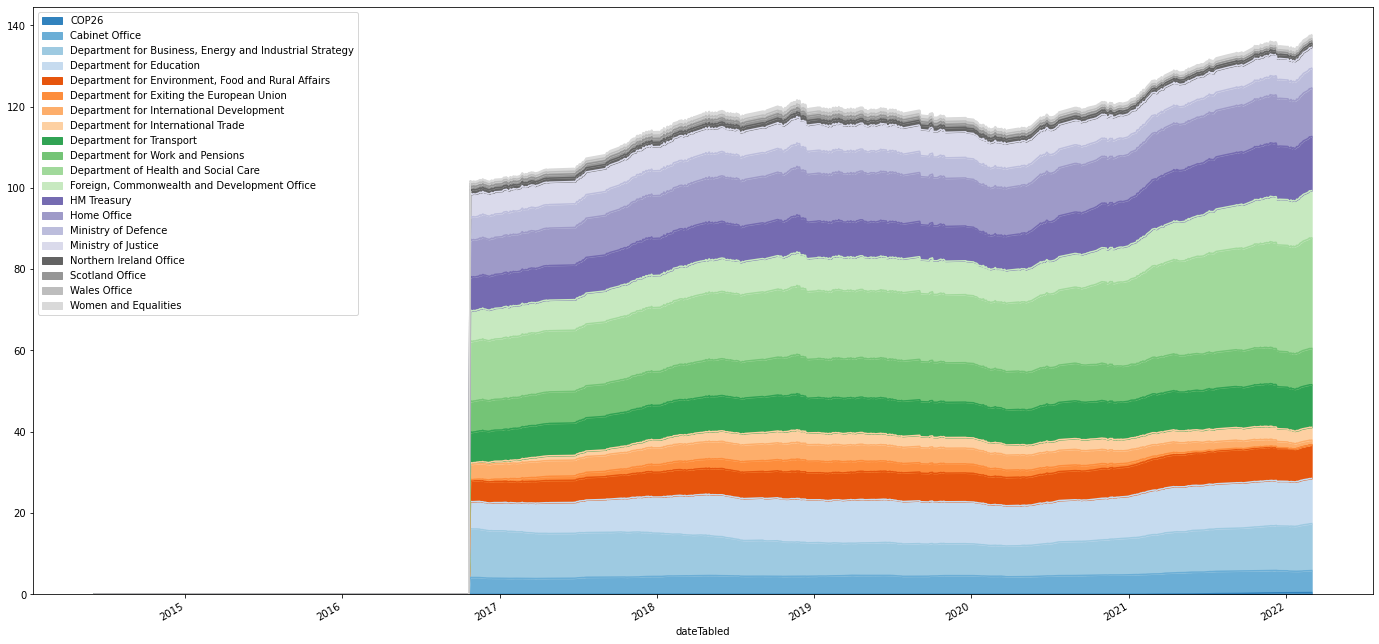

In [ ]:
fig, ax = plt.subplots(figsize=(24, 12))

dept_total_wide_rolling.plot(ax =ax, kind='area', cmap='tab20c')
ax.legend(loc='upper left')

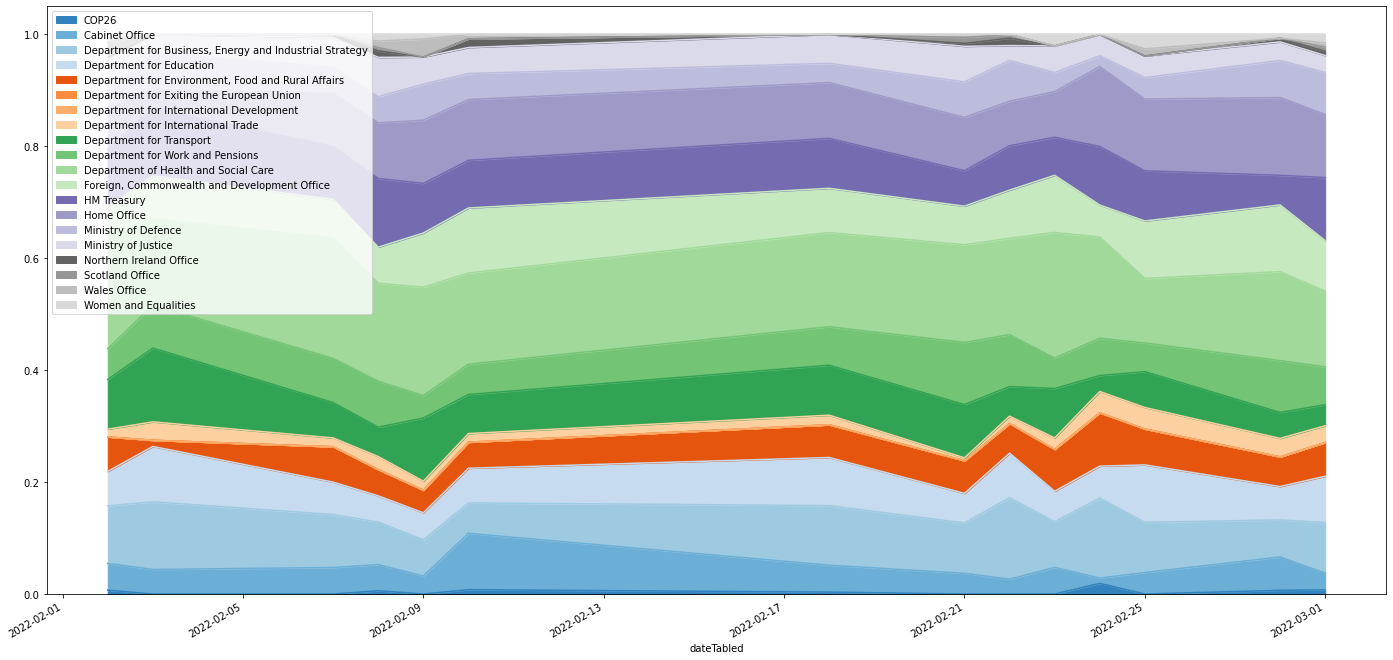

In [ ]:
fig, ax = plt.subplots(figsize=(24, 12))

dept_total_wide_per[dept_total_wide_per.index>'2022-02-01'].plot(ax =ax, kind='area', cmap='tab20c')
ax.legend(loc='upper left')